In [1]:
#Data Preprocessing, Mannual outlier detection, Direct K-means clustering , Use of Demographic variables


In [2]:
#Import MySQL connector
import mysql.connector

In [3]:
#Import Libraries for data manipulation(pandas), data visualization (matplotlib,seaborn) and numerical operations(numpy)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [4]:
#Import libraries for machine learning (KMeans),error handling, metrics, data scaling and statistical functions
from sklearn.cluster import KMeans
import errors as err
import sklearn.metrics as skmet
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew


In [5]:
#Import datetime module from the datetime library
from datetime import datetime


In [6]:
#Import the silhouette_score function from sklearn.metrics for evaluating the quality of clustering
from sklearn.metrics import silhouette_score


In [7]:
#Suppress specific warnings related to SQLAlchemy connectable support in pandas
import warnings
warnings.filterwarnings("ignore", message="pandas only support SQLAlchemy connectable")

In [8]:
#Establishing connection to MySQL database
db_connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='rootpass',
    database='pms_system_bluewaters'
)


In [9]:
#SQL Queries to select guest information and booking details
sql_1 = "SELECT id as guest_id, gender as gender, country_name as country from new_guest_details";
sql_2 ="SELECT booking_no as booking_nu,guest_id as guest_id, room_id as room_id, type as type,room_charge as room_charge,net as net_amount,gross as gross_amount, date as date, status as status from expences";


In [10]:
#Execute SQL queries to load data into pandas dataframes from MySQL database connection
df_guests = pd.read_sql(sql_1,db_connection)
df_expenses = pd.read_sql(sql_2,db_connection)


In [11]:
#Filter the dataframe to include only rows where status = 1, type= Accomodatoin, Year= 2018
#Convert date into date time, invalid date will be set as NaT
df_expenses = df_expenses[df_expenses['status']==1]
df_expenses=df_expenses[df_expenses['type']=='Accommodation']
df_guest_bookings = df_expenses.copy()
df_guest_bookings['date'] = pd.to_datetime(df_guest_bookings['date'], errors='coerce')
df_guest_bookings = df_guest_bookings[df_guest_bookings['date'].dt.year.isin([2018])]
df_guest_bookings

,booking_nu,guest_id,room_id,type,room_charge,net_amount,gross_amount,date,status
0,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1
1,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-12,1
3,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1
4,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-10,1
5,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1
...,...,...,...,...,...,...,...,...,...
13675,5757,3819.0,33,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1
13676,5757,3819.0,36,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1
13677,5757,3819.0,37,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1
13678,5771,3821.0,10,Accommodation,76595.74,76595.74,89999.99,2018-12-31,1


In [12]:
df_guests

,guest_id,gender,country
0,1,Male,Malawi
1,2,Male,Malawi
2,3,Male,Malawi
3,4,Male,Malawi
4,5,Male,Malawi
...,...,...,...
6318,6318,Male,Malawi
6319,6319,Female,Malawi
6320,6321,Male,None
6321,6322,Male,None


In [13]:
#Check for missing values in the dataframe
df_guest_bookings.isnull().any()


booking_nu      False
guest_id         True
room_id         False
type            False
room_charge     False
net_amount      False
gross_amount    False
date            False
status          False
dtype: bool

In [14]:
#Display number of missing values in the dataframe
df_guest_bookings.isnull().sum()


booking_nu       0
guest_id        43
room_id          0
type             0
room_charge      0
net_amount       0
gross_amount     0
date             0
status           0
dtype: int64

In [15]:
#Replace missing values in the guest_id column with mean value
df_guest_bookings['guest_id'].fillna((df_guest_bookings['guest_id'].mean()), inplace=True)
df_guest_bookings


,booking_nu,guest_id,room_id,type,room_charge,net_amount,gross_amount,date,status
0,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1
1,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-12,1
3,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1
4,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-10,1
5,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1
...,...,...,...,...,...,...,...,...,...
13675,5757,3819.0,33,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1
13676,5757,3819.0,36,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1
13677,5757,3819.0,37,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1
13678,5771,3821.0,10,Accommodation,76595.74,76595.74,89999.99,2018-12-31,1


In [16]:
#Checking duplicate records in the dataframe
df_guest_bookings.duplicated().sum()


0

In [17]:
#Display summary of guest booking dataframe
df_guest_bookings.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5708 entries, 0 to 13719
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   booking_nu    5708 non-null   int64         
 1   guest_id      5708 non-null   float64       
 2   room_id       5708 non-null   int64         
 3   type          5708 non-null   object        
 4   room_charge   5708 non-null   float64       
 5   net_amount    5708 non-null   float64       
 6   gross_amount  5708 non-null   float64       
 7   date          5708 non-null   datetime64[ns]
 8   status        5708 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 445.9+ KB


In [18]:
#Display summary statistics for numerical columns in the dataframe
df_guest_bookings.describe()


,booking_nu,guest_id,room_id,room_charge,net_amount,gross_amount,status
count,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.0
mean,5311.112299,2027.147043,33.526804,55809.320540,55809.320540,65575.951386,1.0
std,238.353133,1082.412723,17.132693,18743.825952,18743.825952,22023.995694,0.0
min,2709.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,5145.000000,1176.000000,20.000000,46595.740000,46595.740000,54749.990000,1.0
50%,5296.000000,2172.000000,34.000000,55000.000000,55000.000000,64625.000000,1.0
75%,5512.000000,2928.000000,48.000000,57095.317500,57095.317500,67086.997500,1.0
max,5773.000000,3823.000000,63.000000,350000.000000,350000.000000,411250.000000,1.0


In [19]:
#Check for missing values in the dataframe
df_guests.isnull().any()

guest_id    False
gender       True
country      True
dtype: bool

In [20]:
#Display number of missing values in the dataframe
df_guests.isnull().sum()

guest_id      0
gender       15
country     961
dtype: int64

In [21]:
#Replace all missing values with the string 'Unknown'
df_guests.fillna('unknown',inplace=True)

In [22]:
#Checking duplicate records in the dataframe
df_guests.duplicated().sum()

0

In [23]:
#Count the number of occurances of each unique value in the gender column
df_guestgender_counts = df_guests['gender'].value_counts()
df_guestgender_counts

Male       4206
Female     2102
unknown      15
Name: gender, dtype: int64

In [24]:
##Count the number of occurances of each unique value in the country column
df_guestcountry_counts = df_guests['country'].value_counts()
df_guestcountry_counts

Malawi           4982
unknown           961
United States      43
South Africa       41
India              38
                 ... 
Antarctica          1
Estonia             1
Luxembourg          1
Pakistan            1
Kazakhstan          1
Name: country, Length: 74, dtype: int64

In [25]:
#Display number of missing values in the dataframe
#No missing values
df_guests.isnull().sum()

guest_id    0
gender      0
country     0
dtype: int64

In [26]:
#Display summary of df_guests dataframe
df_guests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6323 entries, 0 to 6322
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guest_id  6323 non-null   int64 
 1   gender    6323 non-null   object
 2   country   6323 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.3+ KB


In [27]:
#Convert guest_id column in the df_guests data frame into float
df_guests['guest_id'] = df_guests['guest_id'].astype(float)


In [28]:
#Merge df_guest_bookings and df_guests on  guest_id using left join to preserve all rows in df_guest_bookings dataframe
df_guest_bookings = pd.merge(df_guest_bookings, df_guests, on='guest_id', how='left')
df_guest_bookings


,booking_nu,guest_id,room_id,type,room_charge,net_amount,gross_amount,date,status,gender,country
0,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi
1,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-12,1,Male,Malawi
2,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi
3,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-10,1,Male,Malawi
4,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi
...,...,...,...,...,...,...,...,...,...,...,...
5703,5757,3819.0,33,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi
5704,5757,3819.0,36,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi
5705,5757,3819.0,37,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi
5706,5771,3821.0,10,Accommodation,76595.74,76595.74,89999.99,2018-12-31,1,Female,Malawi


In [29]:
#Check for missing values in the dataframe
df_guest_bookings.isnull().any()

booking_nu      False
guest_id        False
room_id         False
type            False
room_charge     False
net_amount      False
gross_amount    False
date            False
status          False
gender           True
country          True
dtype: bool

In [30]:
#Display number of missing values in the dataframe
df_guest_bookings.isnull().sum()

booking_nu       0
guest_id         0
room_id          0
type             0
room_charge      0
net_amount       0
gross_amount     0
date             0
status           0
gender          43
country         43
dtype: int64

In [31]:
#Display summary of df_guestbookings dataframe
df_guest_bookings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5708 entries, 0 to 5707
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   booking_nu    5708 non-null   int64         
 1   guest_id      5708 non-null   float64       
 2   room_id       5708 non-null   int64         
 3   type          5708 non-null   object        
 4   room_charge   5708 non-null   float64       
 5   net_amount    5708 non-null   float64       
 6   gross_amount  5708 non-null   float64       
 7   date          5708 non-null   datetime64[ns]
 8   status        5708 non-null   int64         
 9   gender        5665 non-null   object        
 10  country       5665 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 535.1+ KB


In [32]:
#Checking duplicate records in the dataframe
df_guest_bookings.duplicated().sum()

0

In [33]:
#Replace all missing values of gender and country columns with the string 'Unknown'
df_guest_bookings['gender'].fillna('unknown', inplace=True)
df_guest_bookings['country'].fillna('unknown', inplace=True)


In [34]:
#Display summary of df_guestbookings dataframe
df_guest_bookings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5708 entries, 0 to 5707
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   booking_nu    5708 non-null   int64         
 1   guest_id      5708 non-null   float64       
 2   room_id       5708 non-null   int64         
 3   type          5708 non-null   object        
 4   room_charge   5708 non-null   float64       
 5   net_amount    5708 non-null   float64       
 6   gross_amount  5708 non-null   float64       
 7   date          5708 non-null   datetime64[ns]
 8   status        5708 non-null   int64         
 9   gender        5708 non-null   object        
 10  country       5708 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 535.1+ KB


In [35]:
df_guest_bookings

,booking_nu,guest_id,room_id,type,room_charge,net_amount,gross_amount,date,status,gender,country
0,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi
1,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-12,1,Male,Malawi
2,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi
3,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-10,1,Male,Malawi
4,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi
...,...,...,...,...,...,...,...,...,...,...,...
5703,5757,3819.0,33,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi
5704,5757,3819.0,36,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi
5705,5757,3819.0,37,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi
5706,5771,3821.0,10,Accommodation,76595.74,76595.74,89999.99,2018-12-31,1,Female,Malawi


In [36]:
# Identify consecutive days where the same guest stays
df_guest_bookings_n = df_guest_bookings.copy()
df_guest_bookings_n['previous_date'] = df_guest_bookings_n.groupby('guest_id')['date'].shift(1)
df_guest_bookings_n['is_new_booking'] = (df_guest_bookings_n['date'] - df_guest_bookings_n['previous_date']).dt.days != 1
df_guest_bookings_n

,booking_nu,guest_id,room_id,type,room_charge,net_amount,gross_amount,date,status,gender,country,previous_date,is_new_booking
0,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi,NaT,True
1,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-12,1,Male,Malawi,2018-07-11,False
2,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi,NaT,True
3,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-10,1,Male,Malawi,2018-07-09,False
4,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi,2018-07-10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,5757,3819.0,33,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi,2018-12-31,True
5704,5757,3819.0,36,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi,2018-12-31,True
5705,5757,3819.0,37,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi,2018-12-31,True
5706,5771,3821.0,10,Accommodation,76595.74,76595.74,89999.99,2018-12-31,1,Female,Malawi,NaT,True


In [37]:
#New data frame with only the new bookings - not consider the the same guest stay in a few consecutive days
df_guest_bookings_unique =df_guest_bookings_n[df_guest_bookings_n['is_new_booking']==True]
df_guest_bookings_unique

,booking_nu,guest_id,room_id,type,room_charge,net_amount,gross_amount,date,status,gender,country,previous_date,is_new_booking
0,4911,1.0,2,Accommodation,45000.00,45000.00,52875.00,2018-07-11,1,Male,Malawi,NaT,True
2,4900,2.0,5,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi,NaT,True
6,4891,3.0,6,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi,NaT,True
11,4898,4.0,7,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi,NaT,True
16,4901,5.0,8,Accommodation,45000.00,45000.00,52875.00,2018-07-09,1,Male,Malawi,NaT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5703,5757,3819.0,33,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi,2018-12-31,True
5704,5757,3819.0,36,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi,2018-12-31,True
5705,5757,3819.0,37,Accommodation,93617.02,93617.02,110000.00,2018-12-31,1,Male,Malawi,2018-12-31,True
5706,5771,3821.0,10,Accommodation,76595.74,76595.74,89999.99,2018-12-31,1,Female,Malawi,NaT,True


In [38]:
#Checking duplicate records in the dataframe
df_guest_bookings_unique.duplicated()

0       False
2       False
6       False
11      False
16      False
        ...  
5703    False
5704    False
5705    False
5706    False
5707    False
Length: 3266, dtype: bool

In [39]:
#Display number of duplicates in the dataframe
df_guest_bookings_unique.duplicated().sum()

0

In [40]:
#Select specific columns in the dataframe
df_guest_bookings_unique = df_guest_bookings_unique[['guest_id','room_id','booking_nu','net_amount','gross_amount','date','gender','country','status']]
df_guest_bookings_unique

,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status
0,1.0,2,4911,45000.00,52875.00,2018-07-11,Male,Malawi,1
2,2.0,5,4900,45000.00,52875.00,2018-07-09,Male,Malawi,1
6,3.0,6,4891,45000.00,52875.00,2018-07-09,Male,Malawi,1
11,4.0,7,4898,45000.00,52875.00,2018-07-09,Male,Malawi,1
16,5.0,8,4901,45000.00,52875.00,2018-07-09,Male,Malawi,1
...,...,...,...,...,...,...,...,...,...
5703,3819.0,33,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5704,3819.0,36,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5705,3819.0,37,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5706,3821.0,10,5771,76595.74,89999.99,2018-12-31,Female,Malawi,1


In [41]:
# Count the number of occurrences of each unique value in the 'gender' column of the dataframe
df_guest_counts = df_guest_bookings_unique['gender'].value_counts()
df_guest_counts

Male       2189
Female     1040
unknown      37
Name: gender, dtype: int64

In [42]:
#Count the number of occurrences of each unique value in the 'country' column of the dataframe
df_guest_country = df_guest_bookings_unique['country'].value_counts()
df_guest_country

Malawi                                    3129
unknown                                     66
South Africa                                29
United Kingdom                               7
United States                                7
Zimbabwe                                     6
Germany                                      6
Kiribati                                     4
Mozambique                                   2
Pakistan                                     2
India                                        1
American Samoa                               1
Korea, Democratic People's Republic of       1
Poland                                       1
Rwanda                                       1
China                                        1
Nigeria                                      1
Kenya                                        1
Name: country, dtype: int64

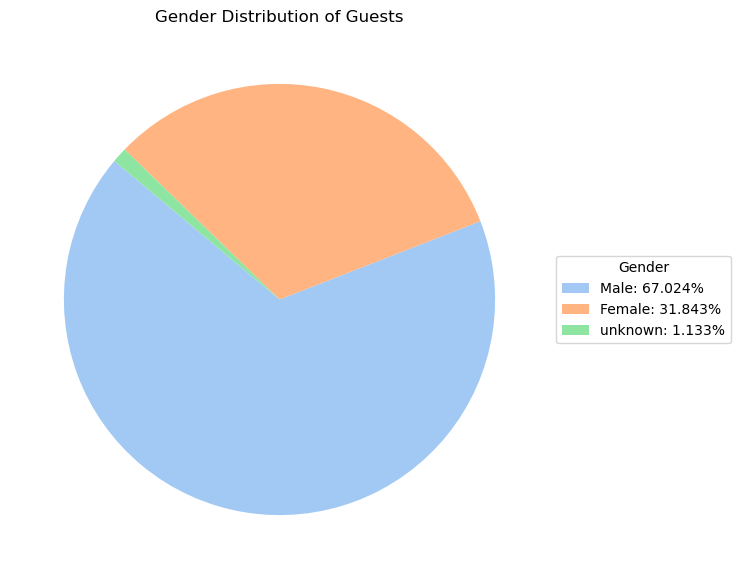

In [43]:
labels = df_guest_counts.index
colors = sns.color_palette('pastel')[0:len(df_guest_counts)]

# Calculate percentages
percentages = 100 * df_guest_counts / df_guest_counts.sum()
legend_labels = [f'{label}: {percentage:.3f}%' for label, percentage in zip(labels, percentages)]

# Plot the pie chart without labels on the slices
plt.figure(figsize=(10, 7))
plt.pie(df_guest_counts, colors=colors, startangle=140, textprops=dict(color="w"))

# Add a legend with the labels and percentages
plt.legend(legend_labels, title="Gender", loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Gender Distribution of Guests')
plt.show()

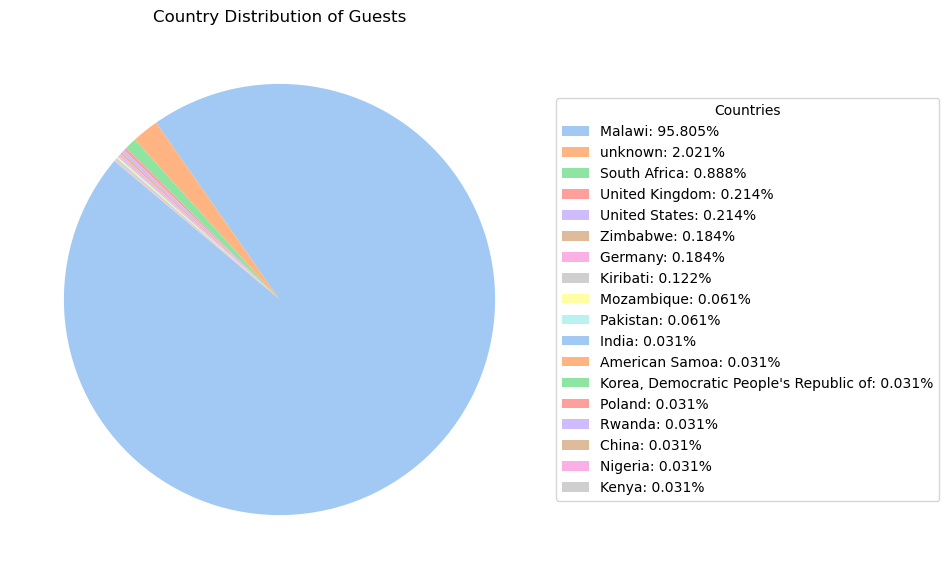

In [44]:
labels = df_guest_country.index
colors = sns.color_palette('pastel')[0:len(df_guest_country)]

# Calculate percentages
percentages = 100 * df_guest_country / df_guest_country.sum()
legend_labels = [f'{label}: {percentage:.3f}%' for label, percentage in zip(labels, percentages)]

# Plot the pie chart without labels on the slices
plt.figure(figsize=(10, 7))
plt.pie(df_guest_country, colors=colors, startangle=140, textprops=dict(color="w"))

# Add a legend with the labels and percentages
plt.legend(legend_labels, title="Countries", loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Country Distribution of Guests')
plt.show()

In [45]:
#Summary statistics for numerical columns in the dataframe
df_guest_bookings_unique.describe()

,guest_id,room_id,booking_nu,net_amount,gross_amount,status
count,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.0
mean,1897.548512,33.372627,5283.091855,56184.303650,66016.556797,1.0
std,1040.551840,17.374124,234.946967,19288.869031,22664.421206,0.0
min,1.000000,1.000000,2709.000000,0.000000,0.000000,1.0
25%,1009.000000,19.000000,5119.000000,45000.000000,52875.000000,1.0
50%,1879.000000,33.000000,5249.000000,55000.000000,64625.000000,1.0
75%,2734.000000,49.000000,5479.000000,60000.000000,70500.000000,1.0
max,3823.000000,63.000000,5773.000000,350000.000000,411250.000000,1.0


In [46]:
#Count the number of guest bookings with net amount = 0
zero_net_amount_count = df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] == 0].shape[0]
zero_net_amount_count


4

In [47]:
# Calculate the percentage of rows in df_guest_bookings_unique where 'net_amount' is 0
percentage=zero_net_amount_count / df_guest_bookings_unique['net_amount'].count() * 100
percentage


0.1224739742804654

In [48]:
# Filter out rows from df_guest_bookings_unique where 'net_amount' is 0
df_guest_bookings_unique = df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] != 0]
df_guest_bookings_unique 


,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status
0,1.0,2,4911,45000.00,52875.00,2018-07-11,Male,Malawi,1
2,2.0,5,4900,45000.00,52875.00,2018-07-09,Male,Malawi,1
6,3.0,6,4891,45000.00,52875.00,2018-07-09,Male,Malawi,1
11,4.0,7,4898,45000.00,52875.00,2018-07-09,Male,Malawi,1
16,5.0,8,4901,45000.00,52875.00,2018-07-09,Male,Malawi,1
...,...,...,...,...,...,...,...,...,...
5703,3819.0,33,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5704,3819.0,36,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5705,3819.0,37,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5706,3821.0,10,5771,76595.74,89999.99,2018-12-31,Female,Malawi,1


In [49]:
#Summary statistics for numerical columns in the dataframe
df_guest_bookings_unique.describe()

,guest_id,room_id,booking_nu,net_amount,gross_amount,status
count,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.0
mean,1896.673342,33.387186,5282.920294,56253.199178,66097.509044,1.0
std,1040.662668,17.379082,234.971393,19200.001616,22560.001994,0.0
min,1.000000,1.000000,2709.000000,0.010000,0.010000,1.0
25%,1009.000000,19.000000,5119.000000,45000.000000,52875.000000,1.0
50%,1879.000000,33.000000,5249.000000,55000.000000,64625.000000,1.0
75%,2734.000000,49.000000,5479.000000,60000.000000,70500.000000,1.0
max,3823.000000,63.000000,5773.000000,350000.000000,411250.000000,1.0


In [50]:
#Count the number of guest bookings with net amount = 0.01
zero_net_amount_count1 = df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] == 0.01].shape[0]
zero_net_amount_count1

5

In [51]:
# Calculate the percentage of rows in df_guest_bookings_unique where 'net_amount' is 0.01
percentage=zero_net_amount_count1 / df_guest_bookings_unique['net_amount'].count() * 100
percentage


0.15328019619865113

In [52]:
# Filter out rows from df_guest_bookings_unique where 'net_amount' is exactly 0.01
df_guest_bookings_unique = df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] != 0.01]
df_guest_bookings_unique 


,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status
0,1.0,2,4911,45000.00,52875.00,2018-07-11,Male,Malawi,1
2,2.0,5,4900,45000.00,52875.00,2018-07-09,Male,Malawi,1
6,3.0,6,4891,45000.00,52875.00,2018-07-09,Male,Malawi,1
11,4.0,7,4898,45000.00,52875.00,2018-07-09,Male,Malawi,1
16,5.0,8,4901,45000.00,52875.00,2018-07-09,Male,Malawi,1
...,...,...,...,...,...,...,...,...,...
5703,3819.0,33,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5704,3819.0,36,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5705,3819.0,37,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5706,3821.0,10,5771,76595.74,89999.99,2018-12-31,Female,Malawi,1


In [53]:
#Summary statistics for numerical columns in the dataframe
df_guest_bookings_unique.describe()

,guest_id,room_id,booking_nu,net_amount,gross_amount,status
count,3257.000000,3257.000000,3257.000000,3257.000000,3257.000000,3257.0
mean,1893.898508,33.389622,5282.288916,56339.556546,66198.978953,1.0
std,1039.045744,17.378470,234.595981,19087.674723,22428.017887,0.0
min,1.000000,1.000000,2709.000000,31914.890000,37500.000000,1.0
25%,1009.000000,19.000000,5119.000000,45000.000000,52875.000000,1.0
50%,1879.000000,33.000000,5249.000000,55000.000000,64625.000000,1.0
75%,2734.000000,49.000000,5479.000000,60000.000000,70500.000000,1.0
max,3823.000000,63.000000,5773.000000,350000.000000,411250.000000,1.0


In [54]:
# Filter and display rows from df_guest_bookings_unique where the 'date' column contains missing (NaN) values
#No garbage values for date 
garbage_dates = df_guest_bookings_unique[df_guest_bookings_unique['date'].isna()]
garbage_dates


,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status


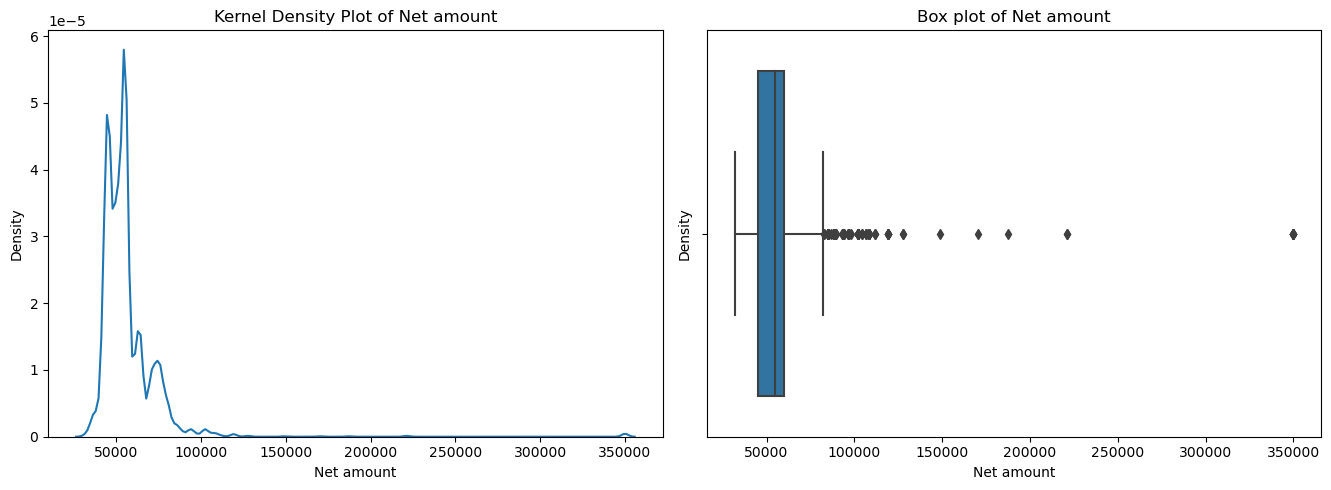

In [55]:
# Plot 1: Kernel Density Estimate (KDE) plot for 'net_amount'
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(x=df_guest_bookings_unique['net_amount'], bw_adjust=0.5)
plt.title('Kernel Density Plot of Net amount')
plt.xlabel('Net amount')
plt.ylabel('Density')

#Plot 2: Box plot for net amount
plt.subplot(1, 3, 2)
sns.boxplot(x=df_guest_bookings_unique['net_amount'])
plt.title('Box plot of Net amount')
plt.xlabel('Net amount')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [56]:
#Calculate the skweness of the net amount
#Skewness > 0 --positive
#Skewness <0 --negative
#Skewness = 0 --Symmetric 
#0.5 - 1 ---moderately positive skewed
#Skeweness >1  --Severe positive skeweness
skewness = skew(df_guest_bookings_unique['net_amount'])
skewness

8.793350070124754

In [57]:
#Calculate Q1 and Q3 of net amount
percentile25 = df_guest_bookings_unique['net_amount'].quantile(0.25)
percentile75 = df_guest_bookings_unique['net_amount'].quantile(0.75)


In [58]:
# Use percentiles to compute the Interquartile Range (IQR)
iqr = percentile75 - percentile25
iqr

15000.0

In [59]:
# Determine the upper and lower bounds for detecting outliers using 1.5 times the IQR
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print(upper_limit,lower_limit)

82500.0 22500.0


In [60]:
#Filter rows in dataframe where 'net_amount' exceeds the calculated upper limit for outlier detection
df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] > upper_limit]


,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status
321,157.0,56,4978,93191.49,109500.00,2018-07-19,Male,China,1
617,379.0,48,5009,97872.34,115000.00,2018-08-01,Female,Malawi,1
761,461.0,28,5025,96463.55,113344.67,2018-09-27,Female,Malawi,1
764,462.0,54,5029,108474.89,127458.00,2018-09-28,Male,Malawi,1
768,465.0,52,5034,104374.47,122640.00,2018-09-28,Female,Malawi,1
...,...,...,...,...,...,...,...,...,...
5693,3784.0,46,5754,85106.38,100000.00,2018-12-31,Male,Malawi,1
5696,3811.0,34,5769,93617.02,110000.00,2018-12-31,Female,Malawi,1
5703,3819.0,33,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1
5704,3819.0,36,5757,93617.02,110000.00,2018-12-31,Male,Malawi,1


In [61]:
#Filter rows in dataframe where 'net_amount' is below the calculated lower limit for outlier detection
df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] < lower_limit]


,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status


In [62]:
#Count the number of outliers in the dataframe
outliers = df_guest_bookings_unique[df_guest_bookings_unique['net_amount'] > upper_limit].shape[0]
outliers


105

In [63]:
# Calculate the percentage of outliers in the df_guest_bookings_unique DataFrame
percentage=outliers / df_guest_bookings_unique['net_amount'].count() * 100
percentage


3.223825606386245

In [64]:
#Use capping method 
new_df_cap = df_guest_bookings_unique.copy()
new_df_cap['net_amount'] = np.where(
    new_df_cap['net_amount'] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap['net_amount'] < lower_limit,
        lower_limit,
        new_df_cap['net_amount']))


In [65]:
new_df_cap.describe()

,guest_id,room_id,booking_nu,net_amount,gross_amount,status
count,3257.000000,3257.000000,3257.000000,3257.000000,3257.000000,3257.0
mean,1893.898508,33.389622,5282.288916,55192.738207,66198.978953,1.0
std,1039.045744,17.378470,234.595981,10997.657771,22428.017887,0.0
min,1.000000,1.000000,2709.000000,31914.890000,37500.000000,1.0
25%,1009.000000,19.000000,5119.000000,45000.000000,52875.000000,1.0
50%,1879.000000,33.000000,5249.000000,55000.000000,64625.000000,1.0
75%,2734.000000,49.000000,5479.000000,60000.000000,70500.000000,1.0
max,3823.000000,63.000000,5773.000000,82500.000000,411250.000000,1.0


In [66]:
new_df_cap

,guest_id,room_id,booking_nu,net_amount,gross_amount,date,gender,country,status
0,1.0,2,4911,45000.00,52875.00,2018-07-11,Male,Malawi,1
2,2.0,5,4900,45000.00,52875.00,2018-07-09,Male,Malawi,1
6,3.0,6,4891,45000.00,52875.00,2018-07-09,Male,Malawi,1
11,4.0,7,4898,45000.00,52875.00,2018-07-09,Male,Malawi,1
16,5.0,8,4901,45000.00,52875.00,2018-07-09,Male,Malawi,1
...,...,...,...,...,...,...,...,...,...
5703,3819.0,33,5757,82500.00,110000.00,2018-12-31,Male,Malawi,1
5704,3819.0,36,5757,82500.00,110000.00,2018-12-31,Male,Malawi,1
5705,3819.0,37,5757,82500.00,110000.00,2018-12-31,Male,Malawi,1
5706,3821.0,10,5771,76595.74,89999.99,2018-12-31,Female,Malawi,1


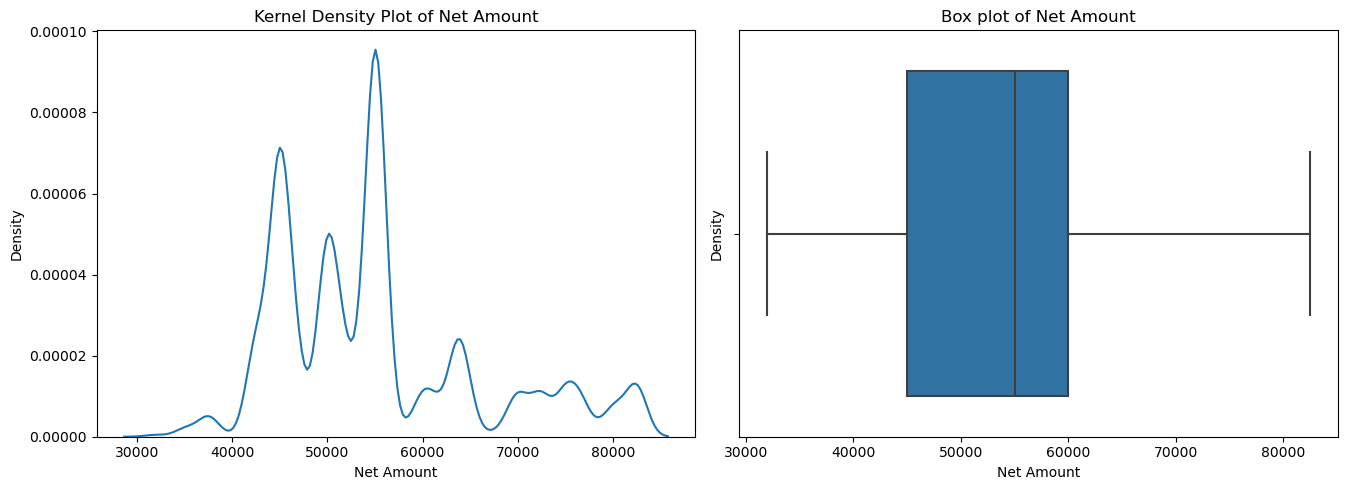

In [67]:
#Compare plots after capping
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(x=new_df_cap['net_amount'], bw_adjust=0.5)
plt.title('Kernel Density Plot of Net Amount')
plt.xlabel('Net Amount')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
sns.boxplot(x=new_df_cap['net_amount'])
plt.title('Box plot of Net Amount')
plt.xlabel('Net Amount')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [68]:
#Calculate the skweness of the net amount
skewness = skew(new_df_cap['net_amount'])
skewness


0.9104365248143129

In [69]:
#current date for Recency Calculation
#current_date = datetime.today()
my_date = datetime(2019, 1, 1)
print(my_date)
current_date = my_date


2019-01-01 00:00:00


In [70]:
#Aggregate the new_df_cap DataFrame to compute RFM (Recency, Frequency, Monetary) metrics for each guest
#first' to take the first occurrence of the gender associated with each guest_id.
df_rfm = new_df_cap.groupby('guest_id').agg({
    'date': lambda x: (current_date - x.max()).days,
    'booking_nu': 'count',
    'net_amount': 'sum',
    'gender':'first',
    'country' :'first'
}).reset_index()
df_rfm.columns = ['guest_id', 'Recency', 'Frequency', 'Monetary','gender','country']


In [71]:
df_rfm

,guest_id,Recency,Frequency,Monetary,gender,country
0,1.0,174,1,45000.00,Male,Malawi
1,2.0,176,1,45000.00,Male,Malawi
2,3.0,176,1,45000.00,Male,Malawi
3,4.0,176,1,45000.00,Male,Malawi
4,5.0,176,1,45000.00,Male,Malawi
...,...,...,...,...,...,...
718,3811.0,1,3,235691.48,Female,Malawi
719,3814.0,1,3,204255.32,Female,Malawi
720,3819.0,1,5,406595.74,Male,Malawi
721,3821.0,1,1,76595.74,Female,Malawi


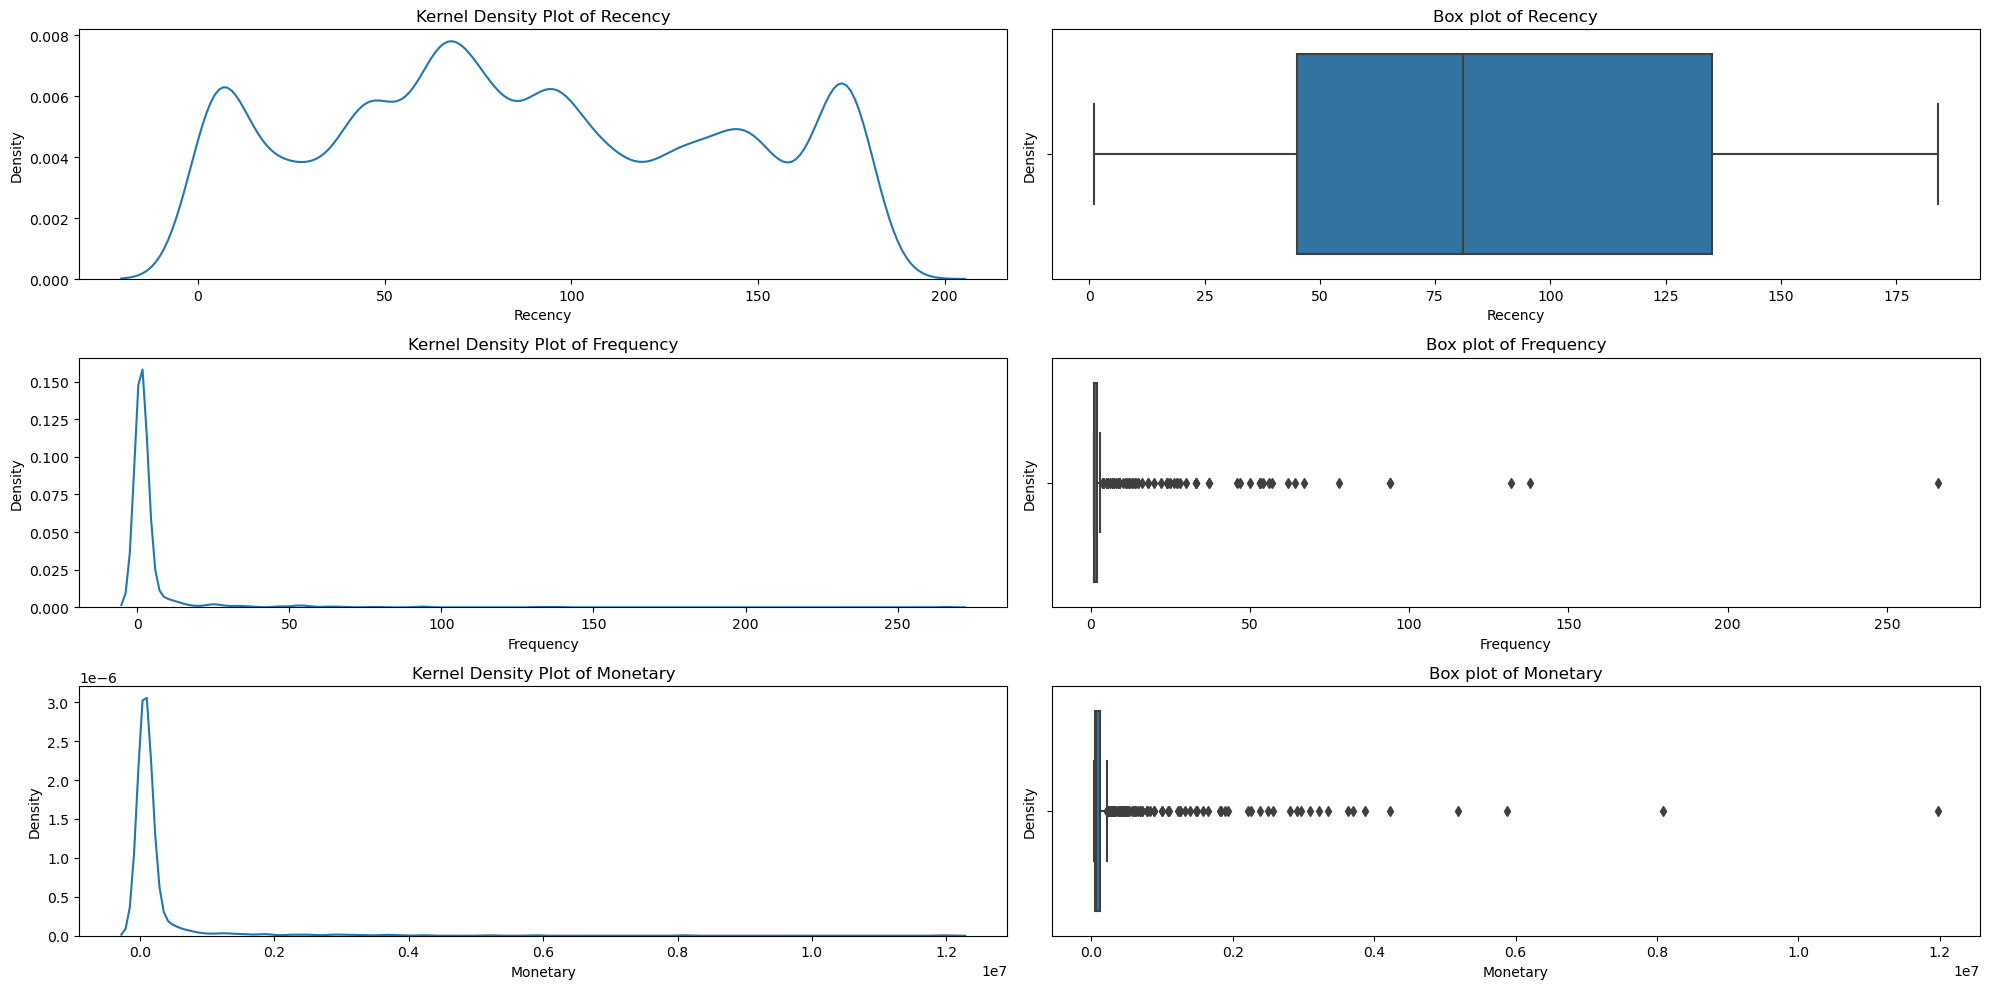

In [72]:
#KDE and box plots for Recency, Frequency and Monetary columns
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
sns.kdeplot(x=df_rfm['Recency'], bw_adjust=0.5)
plt.title('Kernel Density Plot of Recency')
plt.xlabel('Recency')
plt.ylabel('Density')

plt.subplot(3, 2, 2)
sns.boxplot(x=df_rfm['Recency'])
plt.title('Box plot of Recency')
plt.xlabel('Recency')
plt.ylabel('Density')

plt.subplot(3, 2, 3)
sns.kdeplot(x=df_rfm['Frequency'], bw_adjust=0.5)
plt.title('Kernel Density Plot of Frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')

plt.subplot(3, 2, 4)
sns.boxplot(x=df_rfm['Frequency'])
plt.title('Box plot of Frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')


plt.subplot(3, 2, 5)
sns.kdeplot(x=df_rfm['Monetary'], bw_adjust=0.5)
plt.title('Kernel Density Plot of Monetary')
plt.xlabel('Monetary')
plt.ylabel('Density')

plt.subplot(3, 2, 6)
sns.boxplot(x=df_rfm['Monetary'])
plt.title('Box plot of Monetary')
plt.xlabel('Monetary')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


In [73]:
#Calculate skewness
skewness = skew(df_rfm.iloc[:,1:4])
skewness


array([0.10412374, 9.69212598, 8.50464988])

In [74]:
#Select the rows where frequency is higher than 100
df_rfm[df_rfm['Frequency']>100]


,guest_id,Recency,Frequency,Monetary,gender,country
231,1401.0,117,266,11970000.00,Male,Malawi
251,1571.0,110,138,5872340.22,Male,Malawi
336,2172.0,88,132,8084687.50,Female,Malawi


In [75]:
#Mannualy handle the outliers to avoid rows with high frequency values
df_rfm =df_rfm[df_rfm['Frequency']<100]
df_rfm


,guest_id,Recency,Frequency,Monetary,gender,country
0,1.0,174,1,45000.00,Male,Malawi
1,2.0,176,1,45000.00,Male,Malawi
2,3.0,176,1,45000.00,Male,Malawi
3,4.0,176,1,45000.00,Male,Malawi
4,5.0,176,1,45000.00,Male,Malawi
...,...,...,...,...,...,...
718,3811.0,1,3,235691.48,Female,Malawi
719,3814.0,1,3,204255.32,Female,Malawi
720,3819.0,1,5,406595.74,Male,Malawi
721,3821.0,1,1,76595.74,Female,Malawi


In [76]:
#Calculate skewness
skewness = skew(df_rfm.iloc[:,1:4])
skewness


array([0.10771621, 5.51823203, 5.35296663])

In [77]:
# Apply the MinMaxScaler to the 'Recency', 'Frequency', and 'Monetary' columns of df_rfm
scaler_minmax = MinMaxScaler()
df_rfm_minmax = scaler_minmax.fit_transform(df_rfm[['Recency', 'Frequency', 'Monetary']])
df_rfm_minmax = pd.DataFrame(df_rfm_minmax, columns=['Recency', 'Frequency', 'Monetory'])
df_rfm_minmax

,Recency,Frequency,Monetory
0,0.945355,0.000000,0.001709
1,0.956284,0.000000,0.001709
2,0.956284,0.000000,0.001709
3,0.956284,0.000000,0.001709
4,0.956284,0.000000,0.001709
...,...,...,...
715,0.000000,0.021505,0.038726
716,0.000000,0.021505,0.032623
717,0.000000,0.043011,0.071901
718,0.000000,0.000000,0.007842


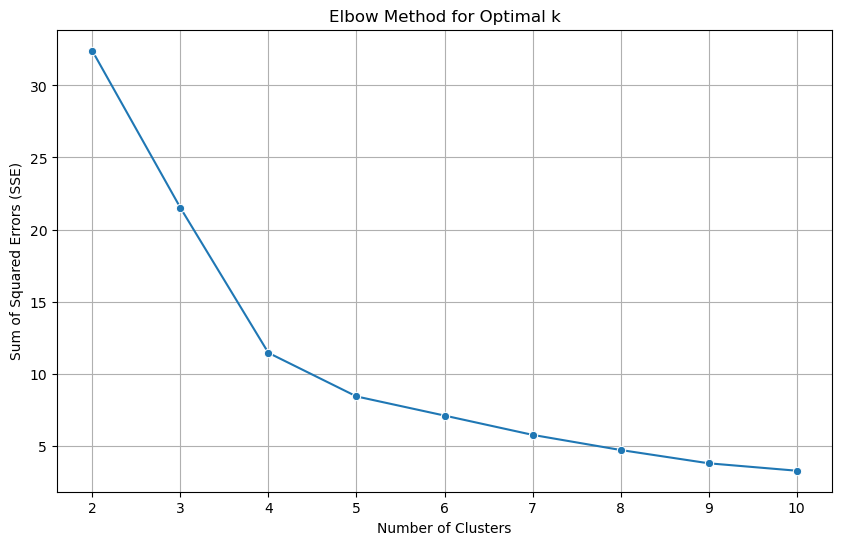

In [78]:
#Elbow method to find the optimal number of clusters
SSE = []
k_range = range(2, 11)  # Trying different number of clusters from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1231)
    kmeans.fit(df_rfm_minmax)  
    SSE.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_range), y=SSE, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [79]:
#Perform K-means clustering
model = KMeans(n_clusters=4)
labels = model.fit_predict(df_rfm_minmax[['Recency', 'Frequency', 'Monetory']])  
centers = model.cluster_centers_

df_rfm_minmax['cluster']=labels
df_rfm_minmax

,Recency,Frequency,Monetory,cluster
0,0.945355,0.000000,0.001709,3
1,0.956284,0.000000,0.001709,3
2,0.956284,0.000000,0.001709,3
3,0.956284,0.000000,0.001709,3
4,0.956284,0.000000,0.001709,3
...,...,...,...,...
715,0.000000,0.021505,0.038726,2
716,0.000000,0.021505,0.032623,2
717,0.000000,0.043011,0.071901,2
718,0.000000,0.000000,0.007842,2


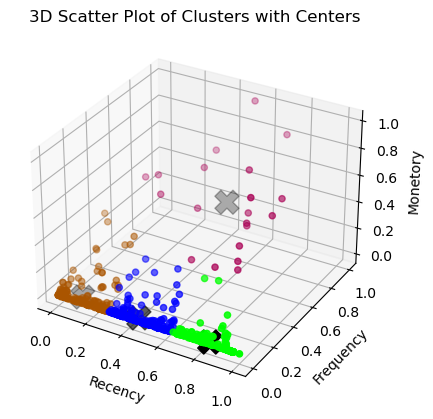

In [80]:
# Create a 3D scatter plot to visualize clusters

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(df_rfm_minmax['Recency'],df_rfm_minmax['Frequency'],df_rfm_minmax['Monetory'],cmap='brg', c=df_rfm_minmax['cluster'])
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=300, c='black', marker='X')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetory')
ax.set_title('3D Scatter Plot of Clusters with Centers')

plt.show()

In [81]:
# Calculate the silhouette score to evaluate the quality of clustering
#Silhouette score should be close to 1 and low inertia value
silhout_score= silhouette_score(df_rfm_minmax[['Recency', 'Frequency', 'Monetory']], labels)
inertia_score = kmeans.inertia_

print(silhout_score,inertia_score)

0.562135702197158 3.2630102267922636


In [82]:
# Align the indices of df_rfm_minmax with those of df_rfm_new
# Assign the cluster labels from df_rfm_minmax to the original dataframe df_rfm_new

df_rfm_new = df_rfm.copy()
df_rfm_minmax.index = df_rfm_new.index
df_rfm_new['cluster'] = df_rfm_minmax['cluster']
df_rfm_new


,guest_id,Recency,Frequency,Monetary,gender,country,cluster
0,1.0,174,1,45000.00,Male,Malawi,3
1,2.0,176,1,45000.00,Male,Malawi,3
2,3.0,176,1,45000.00,Male,Malawi,3
3,4.0,176,1,45000.00,Male,Malawi,3
4,5.0,176,1,45000.00,Male,Malawi,3
...,...,...,...,...,...,...,...
718,3811.0,1,3,235691.48,Female,Malawi,2
719,3814.0,1,3,204255.32,Female,Malawi,2
720,3819.0,1,5,406595.74,Male,Malawi,2
721,3821.0,1,1,76595.74,Female,Malawi,2


In [83]:
#Count the number of data points in each cluster and display the result
df_rfm_new['cluster'].value_counts()

0    276
3    213
2    211
1     20
Name: cluster, dtype: int64

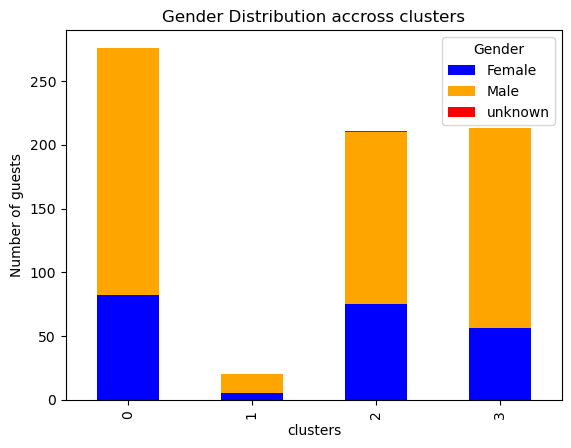

In [84]:
# Plot the gender distribution across clusters as a stacked bar chart
gender_distribution=df_rfm_new.groupby(['cluster','gender']).size().unstack(fill_value=0)
gender_distribution.plot(kind='bar',stacked=True,color=['blue','orange','red'])
plt.title('Gender Distribution accross clusters')
plt.xlabel('clusters')
plt.ylabel('Number of guests')
plt.legend(title='Gender')
plt.show()

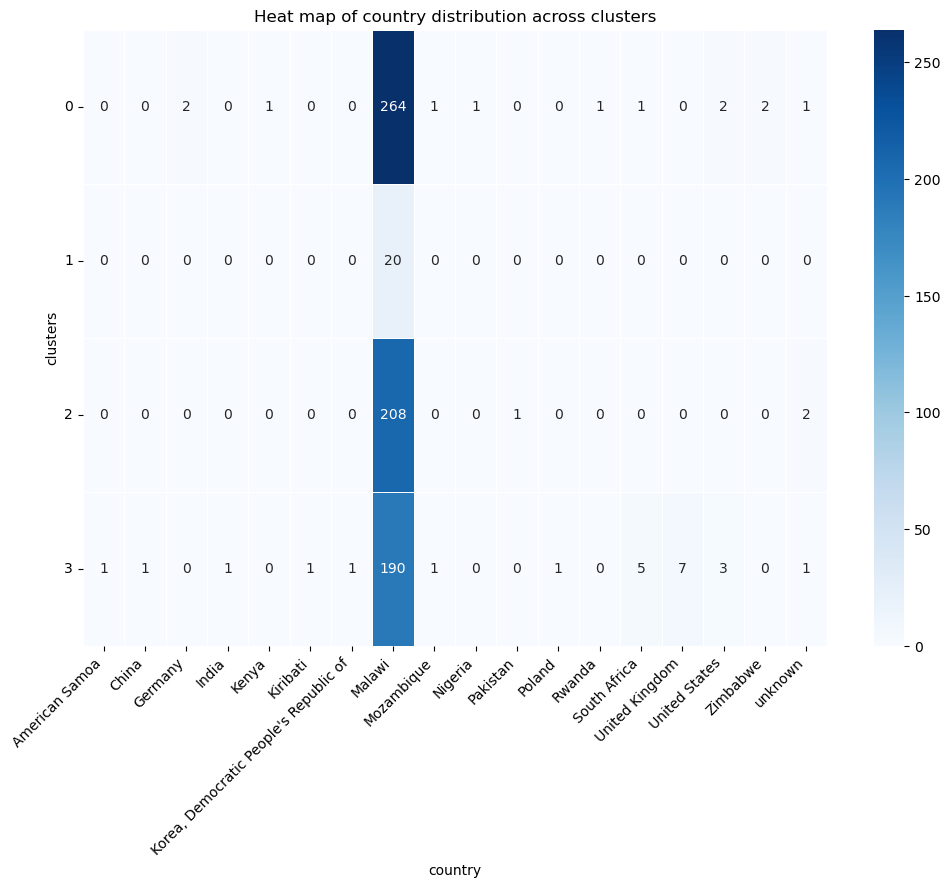

In [85]:
#Plot a heatmap of the country distribution across clusters
country_cluster_pivot = df_rfm_new.pivot_table(index='cluster', columns='country', aggfunc='size', fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(country_cluster_pivot,cmap='Blues',annot=True,fmt='d',linewidths=.5)
plt.title("Heat map of country distribution across clusters")
plt.xlabel("country")
plt.ylabel("clusters")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [86]:
# Apply the StandardScaler to the 'Recency', 'Frequency', and 'Monetary' columns of df_rfm

scaler_standard = StandardScaler()
df_rfm_standard = scaler_standard.fit_transform(df_rfm[['Recency', 'Frequency', 'Monetary']])
df_rfm_standard = pd.DataFrame(df_rfm_standard, columns=['Recency', 'Frequency', 'Monetory'])
df_rfm_standard

,Recency,Frequency,Monetory
0,1.611638,-0.280639,-0.322903
1,1.648962,-0.280639,-0.322903
2,1.648962,-0.280639,-0.322903
3,1.648962,-0.280639,-0.322903
4,1.648962,-0.280639,-0.322903
...,...,...,...
715,-1.616822,-0.078680,0.042178
716,-1.616822,-0.078680,-0.018007
717,-1.616822,0.123279,0.369376
718,-1.616822,-0.280639,-0.262413


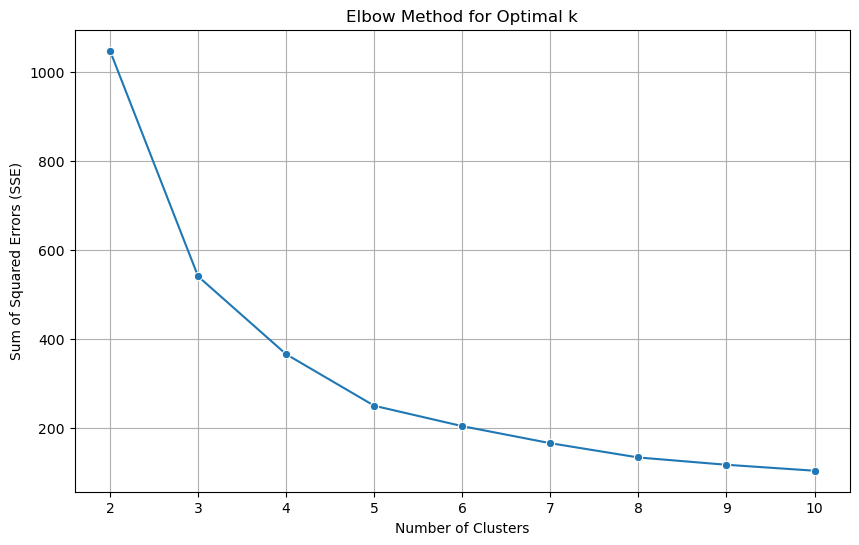

In [87]:
#Elbow method to find the optimal number of clusters
SSE = []
k_range = range(2, 11)  # Trying different number of clusters from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1231)
    kmeans.fit(df_rfm_standard)  
    SSE.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_range), y=SSE, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [88]:
#Perform K-means clustering
model = KMeans(n_clusters=4)
labels = model.fit_predict(df_rfm_standard[['Recency', 'Frequency', 'Monetory']])  
centers = model.cluster_centers_
df_rfm_standard['cluster']=labels
df_rfm_standard



,Recency,Frequency,Monetory,cluster
0,1.611638,-0.280639,-0.322903,0
1,1.648962,-0.280639,-0.322903,0
2,1.648962,-0.280639,-0.322903,0
3,1.648962,-0.280639,-0.322903,0
4,1.648962,-0.280639,-0.322903,0
...,...,...,...,...
715,-1.616822,-0.078680,0.042178,1
716,-1.616822,-0.078680,-0.018007,1
717,-1.616822,0.123279,0.369376,1
718,-1.616822,-0.280639,-0.262413,1


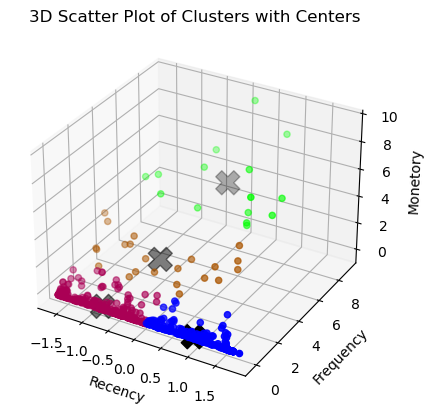

In [89]:
# Create a 3D scatter plot to visualize clusters
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(df_rfm_standard['Recency'],df_rfm_standard['Frequency'],df_rfm_standard['Monetory'],cmap='brg', c=df_rfm_standard['cluster'])
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=300, c='black', marker='X')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetory')
ax.set_title('3D Scatter Plot of Clusters with Centers')

plt.show()

In [90]:
# Calculate the silhouette score to evaluate the quality of clustering
silhout_score= silhouette_score(df_rfm_standard[['Recency', 'Frequency', 'Monetory']], labels)
inertia_score = kmeans.inertia_

print(silhout_score,inertia_score)

0.5487754846528947 103.79168042367101
